## Load Packages

In [1]:
from bs4 import BeautifulSoup
import bs4
from urllib.request import Request, urlopen
import requests
import pandas as pd
import re
import numpy as np
import string
import seaborn as sns
import matplotlib.pyplot as plt

!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

/Users/miles/opt/anaconda3/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Scrape 247 Recruiting Ranks

In [2]:
rankings = []

# Iterate through rankings of last 5 years
for year in range(2018, 2023):
  print(year)
  for i in range(1, 5):
    req = Request(
        url="https://247sports.com/Season/"+str(year)+"-Basketball/CompositeTeamRankings/?ViewPath=~%2FViews%2FSkyNet%2FInstitutionRanking%2F_SimpleSetForSeason.ascx&Page="+str(i), 
        headers={'User-Agent': 'Mozilla/5.0'}
    )
    webpage = urlopen(req).read()

    soup = BeautifulSoup(webpage, features="lxml")
    teams = soup.find_all("li", class_ = "rankings-page__list-item")

    # For every row on the page, append the team and recruiting points to the rankings dataframe
    for row in teams:
      team = row.find("div", class_="team")
      points = row.find("div", class_="points")
      rankings.append([year, team.get_text().strip(), points.get_text().strip()])

# Create pandas dataframe of recruiting rankings
rankings_df = pd.DataFrame(rankings)
rankings_df.columns = ['Year', 'Team', 'Points']
rankings_df['Points'] = pd.to_numeric(rankings_df['Points'], downcast="float")

2018
2019
2020
2021
2022


In [3]:
# Aggregate ranking points across years
agg_rankings_df = rankings_df.groupby('Team', as_index=False)['Points'].sum().sort_values('Points', ascending=False)
agg_rankings_df

Abilene Christian
Air Force
Akron
Alabama
Albany
American
Appalachian State
Arizona
Arizona State
Arkansas
Arkansas-Little Rock
Auburn
Austin Peay
BYU
Ball State
Baylor
Bellarmine
Belmont
Binghamton
Boise State
Boston College
Boston University
Bowling Green
Bradley
Brown
Bucknell
Buffalo
Butler
Cal Poly
Cal State Fullerton
Cal State Northridge
California
Campbell
Central Arkansas
Central Michigan
Charlotte
Chattanooga
Chicago State
Cincinnati
Clemson
Cleveland State
Coastal Carolina
College of Charleston
Colorado
Colorado State
Columbia
Connecticut
Cornell
Creighton
Dartmouth
Davidson
Dayton
DePaul
Denver
Detroit
Drake
Drexel
Duke
Duquesne
East Carolina
East Tennessee State
Eastern Illinois
Eastern Kentucky
Elon
Evansville
FIU
Fairfield
Florida
Florida Atlantic
Florida Gulf Coast
Florida State
Fordham
Fresno State
Furman
Gardner-Webb
George Mason
George Washington
Georgetown
Georgia
Georgia Southern
Georgia State
Georgia Tech
Gonzaga
Grand Canyon
Harvard
Hawaii
Hofstra
Houston
Howard
I

## Scrape ESPN Men's Basketball Records

In [117]:
# Iterate through records of last 5 years

teams_list = []
records_list = []

for year in range(2018, 2023):
  print(year)
  req = Request(
      url="https://www.espn.com/mens-college-basketball/standings/_/season/"+str(year), 
      headers={'User-Agent': 'Mozilla/5.0'}
  )
  webpage = urlopen(req).read()

  soup = BeautifulSoup(webpage, features="lxml")


  # Get teams
  teams = soup.find_all(class_="hide-mobile")
  for team in teams:
    teams_list.append(team.get_text())

  # Get records
  tables = soup.find_all(class_="Table__Scroller")
  for table in tables:
    stats = table.find_all(class_="stat-cell")
    for i in range(len(stats)):
      if (i%10 == 3):
        records_list.append(stats[i].get_text())
print(len(teams_list))

2018
2019
2020
2021
2022
1762


In [102]:
records_df = pd.DataFrame({
    'Team': teams_list,
    'Record': records_list
})
# https://stackoverflow.com/questions/54278595/extract-part-of-a-string-with-regex-before-hyphen-followed-by-digits
records_df['Wins'] = records_df['Record'].str.extract('(.*)-\d+')
records_df['Wins'] = pd.to_numeric(records_df['Wins'], downcast="integer")
records_df

ValueError: arrays must all be same length

In [75]:
# Aggregate team record across years
agg_records_df = records_df.groupby('Team', as_index=False)['Wins'].sum().sort_values('Wins', ascending=False)
agg_records_df

,Team,Wins
101,Gonzaga Bulldogs,155.0
113,Houston Cougars,143.0
131,Kansas Jayhawks,140.0
336,Villanova Wildcats,134.0
72,Duke Blue Devils,131.0
...,...,...
67,Delaware State Hornets,21.0
307,UC San Diego Tritons,20.0
50,Chicago State Cougars,17.0
172,Mississippi Valley State Delta Devils,17.0


## Combine Datasets

### Match Team Names Across Datasets

In [8]:
# Create list of team names for each dataset
team_names_short = agg_rankings_df['Team']
team_names_full = agg_records_df['Team']

278

In [76]:
# Perform fuzzy string matching
tuples_list = [max([(fuzz.token_set_ratio(i,j),j) for j in team_names_short]) for i in team_names_full]

# Map matches to a list and save as a dataframe
similarity_score, fuzzy_match = map(list,zip(*tuples_list))
matches_df = pd.DataFrame({"Full Name":team_names_full, "Shortened Name": fuzzy_match, "Similarity Score":similarity_score})

# Remove inaccurate matches
potential_matches_df = matches_df.loc[df['Similarity Score'] >= 59]
correct_matches_df = potential_matches_df.loc[~potential_matches_df["Shortened Name"].isin(['NC State', 'Florida', 'Alabama', 'Texas', 'Utah', 'Maryland', 'Arkansas', 'Illinois', 'Washington', 'Houston',
                                                             'Tennessee', 'Southern Miss', 'Michigan', 'North Carolina', 'Kentucky', 'Jacksonville', 'UMass Lowell',
                                                             'North Dakota State', 'Purdue', "St. Mary's", 'Kansas', 'Bellarmine', 'Boston University', 'Idaho', 'San Diego',
                                                             'Tennessee State', 'Louisiana', 'Missouri State', 'Mississippi State', 'California', 'Northwestern',
                                                             'North Dakota', 'Colorado', 'Connecticut'])][['Full Name', 'Shortened Name']]
correct_matches_df

,Full Name,Shortened Name
101,Gonzaga Bulldogs,Gonzaga
336,Villanova Wildcats,Villanova
72,Duke Blue Devils,Duke
337,Virginia Cavaliers,Virginia
22,Belmont Bruins,Belmont
...,...,...
58,Columbia Lions,Columbia
257,San José State Spartans,San Jose State
286,Tarleton Texans,Tarleton State
50,Chicago State Cougars,Chicago State


In [12]:
# Append proper matches manually where necessary
manual_pairings = [
    ["NC State Wolfpack", "NC State"],
    ["Florida Gators", "Florida"],
    ["Alabama Crimson Tide", "Alabama"],
    ["Texas Longhorns", "Texas"],
    ["Utah Utes", "Utah"],
    ["Maryland Terrapins", "Maryland"],
    ["Arkansas Razorbacks", "Arkansas"],
    ["Illinois Fighting Illini", "Illinois"],
    ["Washington Huskies", "Washington"],
    ["Houston Cougars", "Houston"],
    ["Tennessee Volunteers", "Tennessee"],
    ["Southern Miss Golden Eagles", "Southern Miss"],
    ["Michigan Wolverines", "Michigan"],
    ["North Carolina Tar Heels", "North Carolina"],
    ["Kentucky Wildcats", "Kentucky"],
    ["Jacksonville Dolphins", "Jacksonville"],
    ["UMass Lowell River Hawks", "UMass Lowell"],
    ["North Dakota State Bison", "North Dakota State"],
    ["Purdue Boilermakers", "Purdue"],
    ["Saint Mary's Gaels", "St. Mary's"],
    ["Kansas Jayhawks", "Kansas"],
    ["Bellarmine Knights", "Bellarmine"],
    ["Boston University Terriers", "Boston University"],
    ["Idaho Vandals", "Idaho"],
    ["San Diego Toreros", "San Diego"],
    ["Tennessee State Tigers", "Tennessee State"],
    ["Louisiana Ragin' Cajuns", "Louisiana"],
    ["Missouri State Bears", "Missouri State"],
    ["Mississippi State Bulldogs", "Mississippi State"],
    ["California Golden Bears", "California"],
    ["Northwestern Wildcats", "Northwestern"],
    ["North Dakota Fighting Hawks", "North Dakota"],
    ["Colorado Buffaloes", "Colorado"],
    ["South Florida Bulls", "USF",],
    ["UT Rio Grande Valley Vaqueros", "Texas-Rio Grande Valley"],
    ["SE Louisiana Lions", "Southeastern Louisiana"],
    ["Central Michigan Chippewas", "Central Michigan"],
    ["East Tennessee State Buccaneers", "East Tennessee State"],
    ["Eastern Illinois Panthers", "Eastern Illinois"],
    ["Eastern Kentucky Colonels", "Eastern Kentucky"],
    ["Florida International Panthers", "FIU"],
    ["George Washington Colonials", "George Washington"],
    ["Hawai'i Rainbow Warriors", "Hawaii"],
    ["UIC Flames", "Illinois-Chicago"],
    ["Loyola Maryland Greyhounds", "Loyola Maryland"],
    ["UMass Minutemen", "Massachusetts"],
    ["Middle Tennessee Blue Raiders", "Middle Tennessee State"],
    ["Kansas City Roos", "Missouri-Kansas City"],
    ["Mount St. Mary's Mountaineers", "Mount St. Mary's"],
    ["North Texas Mean Green", "North Texas"],
    ["Sam Houston Bearkats", "Sam Houston State"],
    ["UConn Huskies", "Connecticut"]
]
manual_pairings_df = pd.DataFrame(manual_pairings)
manual_pairings_df.columns = ['Full Name', 'Shortened Name']

,Full Name,Shortened Name
0,NC State Wolfpack,NC State
1,Florida Gators,Florida
2,Alabama Crimson Tide,Alabama
3,Texas Longhorns,Texas
4,Utah Utes,Utah
5,Maryland Terrapins,Maryland
6,Arkansas Razorbacks,Arkansas
7,Illinois Fighting Illini,Illinois
8,Washington Huskies,Washington
9,Houston Cougars,Houston


In [77]:
# Concatenate correct matches and manual pairings
name_pairings_key=pd.concat([correct_matches_df, manual_pairings_df])

# Merge datasets using name pairings as a key
rankings_versus_wins = agg_records_df.merge(name_pairings_key, left_on='Team', right_on='Full Name').merge(agg_rankings_df, left_on='Shortened Name', right_on='Team')[['Shortened Name', 'Points', 'Wins']]
rankings_versus_wins

,Shortened Name,Points,Wins
0,Gonzaga,266.730011,155.0
1,Houston,236.229996,143.0
2,Kansas,323.239990,140.0
3,Villanova,282.630005,134.0
4,Duke,350.179993,131.0
...,...,...,...
273,Columbia,48.880001,28.0
274,San Jose State,80.770004,28.0
275,Tarleton State,14.630000,24.0
276,Chicago State,0.000000,17.0


## Graphs and Analysis

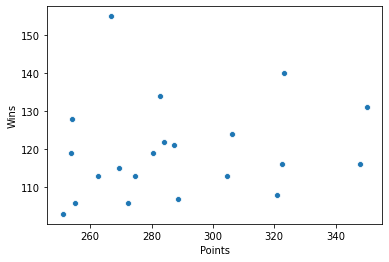

In [65]:
sns.scatterplot(data=data, x="Points", y="Wins")

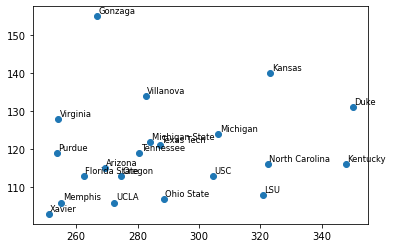

In [72]:
plt.scatter(data['Points'], data['Wins']);

# Loop through the data points 
for i, team in enumerate (data['Shortened Name']):
    plt.text(data['Points'][i]+0.5, data['Wins'][i]+0.8, team, size="small")